In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.experimental import enable_halving_search_cv  
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [ ]:
# importing our data and printing out the first 10 rows
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/

pd.set_option('max_columns', 21)
data = pd.read_csv("voice.csv")
data.head(10)

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks
   meanfreq        sd    median       Q25       Q75       IQR       skew  \
0  0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1  0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2  0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3  0.151228  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4  0.135120  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   
5  0.132786  0.079557  0.119090  0.067958  0.209592  0.141634   1.932562   
6  0.150762  0.074463  0.160106  0.092899  0.205718  0.112819   1.530643   
7  0.160514  0.076767  0.144337  0.110532  0.231962  0.121430   1.397156   
8  0.142239  0.078018  0.138587  0.088206  0.208587  0.120381   1.099746   
9  0.134329  0.080350  0.121451  0.075580  0.201957  0.126377   1.190368   

          kurt    sp.ent       sfm  ...  centroid   meanfun    minfun  \
0   274.402906  0.893369

In [ ]:
# reading in our dataset, replacing 'male' and 'female' values with 1 and 0, respectively
data = pd.read_csv("voice.csv")
data["label"] = data["label"].map(dict(male=1, female=0))

# using scaler to give all the values in the dataset a new value from 0 to 1.
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_feat, index=data.index, columns=data.columns)
#print(scaled_df.head(10))

y_data = scaled_df.pop("label")
y_data.columns = ["ID", "label"]
X_data = scaled_df

# filtering our data, removing constant features (ones that do not cross the threshold of 0.01)
qconstant_filter = VarianceThreshold(threshold=0.01)
qconstant_filter.fit(X_data)
print(len(X_data.columns[qconstant_filter.get_support()]))

qconstant_columns = [column for column in X_data.columns
                    if column not in X_data.columns[qconstant_filter.get_support()]]
     
for column in qconstant_columns:
    print("Lose the column:", column)

# finding highly correlated features and removing them
# the reference used for this part of the code can be found at https://stackabuse.com/applying-filter-methods-in-python-for-feature-selection/
correlated_features = set()
correlation_matrix = X_data.corr()
#print(correlation_matrix)
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            column_name = correlation_matrix.columns[i]
            correlated_features.add(column_name)
print(correlated_features)
X_data.drop(labels=correlated_features, axis=1, inplace=True)

# split into training and test data (test data makes up 20% of the original data)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

19
Lose the column: minfun
{'centroid', 'dfrange', 'kurt'}


For every model: <br>
  <> Randomized search <br>
  <> Regularization <br>
  <> Find probabilities <br>
  <> Cross-validation <br>
<br>
Try out all of the six models, decide on four best and combine them for the result.

In [ ]:
# logistic regression
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(random_state=42, max_iter=1000, solver="saga", penalty="l1", C=0.75) 

k_folds = KFold(n_splits = 5, random_state=42, shuffle=True)

grid = {"penalty": ['l1', 'l2', 'elasticnet'],
        "C": [0.001, 0.01, 0.1, 1, 10],
        "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

# {'solver': 'saga', 'penalty': 'l1', 'C': 1}

grid = {"penalty": ['l1', 'l2', 'elasticnet'],
        "C": [0.75, 1, 3, 5],
        "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

# {'solver': 'saga', 'penalty': 'l1', 'C': 0.75}

# using randomized search to find the best parameters for our model
LR_random = RandomizedSearchCV(estimator=LR_model, param_distributions=grid, n_iter=100, cv=4, random_state=42).fit(X_train, y_train)
print(LR_random.best_params_)

# using cross-validation to iterate through our train and test data and find the generalized scores for this model
LR_scores = cross_val_score(LR_model, X_train, y_train, cv = k_folds)
print(LR_scores)
sum = 0
for i in range(len(LR_scores)):
  sum += LR_scores[i]

print(sum/5)

# scores before scaler: [0.88954635 0.88954635 0.91913215 0.88954635 0.88932806]
# scores after scaler: [0.95266272 0.96449704 0.97238659 0.9704142  0.97035573]
# average before filter: 0.9660632566987083
# average after filter: 0.9660632566987083

LR_proba = cross_val_predict(LR_model, X_train, y_train, cv=k_folds, method='predict_proba')
print(LR_proba)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
176 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py

{'solver': 'saga', 'penalty': 'l1', 'C': 0.75}
[0.96055227 0.96844181 0.97830375 0.97238659 0.9743083 ]
0.9707985437082428
[[0.24799568 0.75200432]
 [0.9988536  0.0011464 ]
 [0.98856224 0.01143776]
 ...
 [0.00400545 0.99599455]
 [0.0054584  0.9945416 ]
 [0.04516017 0.95483983]]


In [ ]:
# F-measure, recall and precision for LR
LR_pred = cross_val_predict(LR_model, X_train, y_train, cv=k_folds, method='predict')
print("F-measure:", f1_score(y_train, LR_pred, average='binary'))
print("Recall:", recall_score(y_train, LR_pred, average='binary'))
print("Precision:", precision_score(y_train, LR_pred, average='binary'))

F-measure: 0.9659000793021412
Recall: 0.9767441860465116
Precision: 0.9552941176470588


In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
KNN_model = KNeighborsClassifier(n_neighbors=3, leaf_size=1, algorithm="auto", weights="uniform")

# the first grid
grid = {"n_neighbors": [1, 5, 10, 25, 50, 100],
        "weights": ['uniform', 'distance'],
        "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
        "leaf_size": [10, 25, 50, 75, 100, 200]}

# the second, optimized grid
grid = {"n_neighbors": [3, 5, 7],
        "weights": ['uniform', 'distance'],
        "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
        "leaf_size": [1, 2, 3, 4, 5]}

# using randomized search to find the best parameters for our model
KNN_random = RandomizedSearchCV(estimator=KNN_model, param_distributions=grid, n_iter=150, cv=4, random_state=42).fit(X_train, y_train)
print(KNN_random.best_params_)

# using cross-validation to iterate through our train and test data and find the generalized scores for this model
KNN_scores = cross_val_score(KNN_model, X_train, y_train, cv = k_folds)
print(KNN_scores)

# finding the average result for this model from the scores generated by the code above
sum = 0
for i in range(len(KNN_scores)):
  sum += KNN_scores[i]

print(sum/5)

# scores with default hyperparameters [0.69230769 0.70414201 0.75936884 0.6765286 0.67786561]
# scores with first new parameters [0.70414201 0.71203156 0.71400394 0.67850099 0.7055336]
# scores after scaler: [0.96844181 0.97238659 0.97435897 0.97435897 0.98418972]
# average before filter: 0.974747214880994
# average after filter: 0.9763259037506529
# average after changing parameters: 0.9794817222910869

KNN_proba = cross_val_predict(KNN_model, X_train, y_train, cv=k_folds, method='predict_proba')
print(KNN_proba)

[0.97633136 0.97830375 0.98027613 0.97633136 0.98616601]
0.9794817222910869
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
# F-measure, recall and precision for KNN
KNN_pred = cross_val_predict(KNN_model, X_train, y_train, cv=k_folds, method='predict')
print("F-measure:", f1_score(y_train, KNN_pred, average='binary'))
print("Recall:", recall_score(y_train, KNN_pred, average='binary'))
print("Precision:", precision_score(y_train, KNN_pred, average='binary'))

F-measure: 0.9791666666666666
Recall: 0.9799518845228549
Precision: 0.978382706164932


In [ ]:
# random forest 
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=600, min_samples_split=4, min_samples_leaf=3, max_features="auto", max_depth=10, bootstrap=False)

# random grid to narrow down the possibilities
pprint(rf_model.get_params())
grid = {'n_estimators': [100, 250, 500, 750, 1000, 1500, 2000],
        'max_depth': [10, 25, 50, 75, 100, 150, 200, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 10],
        'max_features': ['auto', 'sqrt'],
        'bootstrap': [True, False]}

grid = {'n_estimators': [300, 400, 500, 600, 700],
        'max_depth': [5, 7, 10, 12],
        'min_samples_split': [4, 5, 6, 7, 8],
        'min_samples_leaf': [1, 2, 3],
        'max_features': ['auto', 'sqrt'],
        'bootstrap': [True, False]}
#max_depth gives a higher accuracy with None, but we're using lower values here to prevent overfitting

# using randomized search to find the best parameters for our model
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=grid, n_iter=100, cv=4, random_state=42).fit(X_train, y_train)
rf_random.best_params_

# using cross-validation to iterate through our train and test data and find the generalized scores for this model
rf_scores = cross_val_score(rf_model, X_train, y_train, cv = k_folds)
print(rf_scores)

# finding the average result for this model from the scores generated by the code above
sum = 0
for i in range(len(rf_scores)):
  sum += rf_scores[i]

print(sum/5)

# scores before scaler: [0.97830375 0.98224852 0.98816568 0.9704142  0.98418972]
# scores after scaler: [0.97830375 0.98224852 0.98816568 0.9704142  0.98221344]
# average score after: 0.9786912084570947
# average score after scaler and filter without new params: 0.9786912084570947

rf_proba = cross_val_predict(rf_model, X_train, y_train, cv=k_folds, method='predict_proba')
print(rf_proba)

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 600,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
[0.97633136 0.98027613 0.98224852 0.97238659 0.98221344]
0.9786912084570947
[[1.74231726e-01 8.25768274e-01]
 [9.80434958e-01 1.95650424e-02]
 [9.97229788e-01 2.77021189e-03]
 ...
 [1.38970545e-03 9.98610295e-01]
 [2.55543288e-04 9.99744457e-01]
 [2.48021512e-03 9.97519785e-01]]


In [ ]:
# F-measure, recall and precision for rf
rf_pred = cross_val_predict(rf_model, X_train, y_train, cv=k_folds, method='predict')
print("F-measure:", f1_score(y_train, rf_pred, average='binary'))
print("Recall:", recall_score(y_train, rf_pred, average='binary'))
print("Precision:", precision_score(y_train, rf_pred, average='binary'))

F-measure: 0.9782608695652173
Recall: 0.9743384121892542
Precision: 0.9822150363783346


In [ ]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()

# as Gaussian Naive Bayes has only two parameters, we tried some models ourselves and came to the conclusion that the default parameters worked best

# using cross-validation to iterate through our train and test data and find the generalized scores for this model
gnb_scores = cross_val_score(gnb_model, X_train, y_train, cv = k_folds)
print(gnb_scores)

# finding the average result for this model from the scores generated by the code above
sum = 0
for i in range(len(gnb_scores)):
  sum += gnb_scores[i]
print(sum/5)

# scores before scaler: [0.86982249 0.90138067 0.8974359  0.86390533 0.8972332 ]
# scores after scaler: [0.8816568  0.90138067 0.89940828 0.8678501  0.90316206]
# average before filter: 0.8906915826648267
# average after filter: 0.9167364408167084

gnb_proba = cross_val_predict(gnb_model, X_train, y_train, cv=k_folds, method='predict_proba')
print(gnb_proba)

[0.91321499 0.9112426  0.92504931 0.90729783 0.92687747]
0.9167364408167084
[[2.87219354e-01 7.12780646e-01]
 [9.99997333e-01 2.66718574e-06]
 [9.99991217e-01 8.78316270e-06]
 ...
 [5.68725809e-02 9.43127419e-01]
 [2.23935197e-04 9.99776065e-01]
 [2.57981384e-04 9.99742019e-01]]


In [ ]:
# F-measure, recall and precision for gnb
gnb_pred = cross_val_predict(gnb_model, X_train, y_train, cv=k_folds, method='predict')
print("F-measure:", f1_score(y_train, gnb_pred, average='binary'))
print("Recall:", recall_score(y_train, gnb_pred, average='binary'))
print("Precision:", precision_score(y_train, gnb_pred, average='binary'))

F-measure: 0.917352134743439
Recall: 0.9390537289494787
Precision: 0.8966309341500766


In [ ]:
# multilayer perceptron
from sklearn.neural_network import MLPClassifier

#the final model with 0.9782959515400986 average accuracy
MLP_model = MLPClassifier(random_state=42, max_iter=5000, solver="lbfgs", learning_rate="constant", hidden_layer_sizes=300, alpha=0.3).fit(X_train, y_train)

#pprint(MLP_model.get_params())
grid = {'solver': ['lbfgs', 'adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.1, 0.5], 
        'hidden_layer_sizes': [5, 10, 25, 50, 100],
        'learning_rate': ['constant', 'adaptive']}

# {'solver': 'lbfgs', 'learning_rate': 'adaptive', 'hidden_layer_sizes': 5, 'alpha': 0.1}
# {'solver': 'lbfgs', learning_rate': 'constant', 'hidden_layer_sizes': 100, 'alpha': 0.5}

grid = {'alpha': [0.3, 0.4, 0.5, 0.6], 
        'hidden_layer_sizes': [200, 250, 300, 350],
        'learning_rate': ['constant', 'adaptive']}

# {'solver': 'lbfgs', 'learning_rate': 'adaptive', 'hidden_layer_sizes': 200, 'alpha': 0.5}
# {'hidden_layer_sizes': 250, 'alpha': 0.4}
# {'learning_rate': 'constant', 'hidden_layer_sizes': 300, 'alpha': 0.3}

# using randomized search to find the best parameters for our model
#MLP_random = RandomizedSearchCV(estimator=MLP_model, param_distributions=grid, n_iter=100, cv=3, random_state=42).fit(X_train, y_train)
#print(MLP_random.best_params_)

# using cross-validation to iterate through our train and test data and find the generalized scores for this model
#MLP_scores = cross_val_score(MLP_model, X_train, y_train, cv = k_folds)
#print(MLP_scores)

# finding the average result for this model from the scores generated by the code above
"""
sum = 0
for i in range(len(MLP_scores)):
  sum += MLP_scores[i]

print(sum/5)
"""

# default: [0.90335306 0.86390533 0.92110454 0.91321499 0.93873518]
# new parameters: [0.96055227 0.9704142  0.9704142  0.97830375 0.9743083 ]
# after scaler: [0.9566075  0.96646943 0.97633136 0.98027613 0.97628458]
# average before filter: 0.9711938006252387
# average after filter: 0.9711922414263551
# average score after new parameters (first grid): 0.9767180422698818
# average score after new parameters (second, more specific grid): 0.9782959515400986

MLP_proba = cross_val_predict(MLP_model, X_train, y_train, cv=k_folds, method='predict_proba')
print(MLP_proba)

[[1.86393095e-02 9.81360690e-01]
 [9.83845330e-01 1.61546698e-02]
 [9.99786751e-01 2.13249169e-04]
 ...
 [8.99367605e-06 9.99991006e-01]
 [1.78005677e-05 9.99982199e-01]
 [4.36344318e-03 9.95636557e-01]]


In [ ]:
# F-measure, recall and precision for MLP
MLP_pred = cross_val_predict(MLP_model, X_train, y_train, cv=k_folds, method='predict')
print("F-measure:", f1_score(y_train, MLP_pred, average='binary'))
print("Recall:", recall_score(y_train, MLP_pred, average='binary'))
print("Precision:", precision_score(y_train, MLP_pred, average='binary'))

F-measure: 0.9778850020104544
Recall: 0.97514033680834
Precision: 0.9806451612903225


In [ ]:
# SVM
from sklearn.svm import SVC
svm_model = SVC(random_state=42, probability=True, kernel='poly', gamma=0.6, C=0.4)

grid = {'C': [0.001, 0.1, 1, 10, 100, 1000], 
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'poly', 'sigmoid', 'linear']} 

# {'kernel': 'poly', 'gamma': 0.1, 'C': 100}

grid = {'C': [0.05, 0.1, 0.25, 0.5], 
        'gamma': [0.5, 0.25, 0.1, 0.075, 0.05],
        'kernel': ['rbf', 'poly', 'sigmoid', 'linear']} 

# {'kernel': 'poly', 'gamma': 0.5, 'C': 0.5}

grid = {'C': [0.4, 0.5, 0.6, 0.7], 
        'gamma': [0.6, 0.5, 0.4, 0.3],
        'kernel': ['rbf', 'poly', 'sigmoid', 'linear']} 

# {'kernel': 'poly', 'gamma': 0.6, 'C': 0.4}

# using randomized search to find the best parameters for our model
#svm_random = RandomizedSearchCV(estimator=svm_model, param_distributions=grid, n_iter=100, cv=3, random_state=42).fit(X_train, y_train)
#print(svm_random.best_params_)

# using cross-validation to iterate through our train and test data and find the generalized scores for this model
svm_scores = cross_val_score(svm_model, X_train, y_train, cv = k_folds)
print(svm_scores)

# scores before: [0.67061144 0.68047337 0.71597633 0.67850099 0.6541502 ]
# average score after (filter and scaler): 0.9759298672342152 
# average score after with new parameters: 0.9767180422698818

# finding the average result for this model from the scores generated by the code above
sum = 0
for i in range(len(svm_scores)):
  sum += svm_scores[i]
print(sum/5)

svm_proba = cross_val_predict(svm_model, X_train, y_train, cv=k_folds, method='predict_proba')
print(svm_proba)

[0.96646943 0.97830375 0.97830375 0.98027613 0.98023715]
0.9767180422698818
[[1.38434510e-01 8.61565490e-01]
 [9.99909263e-01 9.07370899e-05]
 [9.97682894e-01 2.31710570e-03]
 ...
 [8.69167159e-08 9.99999913e-01]
 [3.36807035e-06 9.99996632e-01]
 [1.35166421e-02 9.86483358e-01]]


In [ ]:
# F-measure, recall and precision for svm
svm_pred = cross_val_predict(svm_model, X_train, y_train, cv=k_folds, method='predict')
print("F-measure:", f1_score(y_train, svm_pred, average='binary'))
print("Recall:", recall_score(y_train, svm_pred, average='binary'))
print("Precision:", precision_score(y_train, svm_pred, average='binary'))

F-measure: 0.9763527054108218
Recall: 0.9767441860465116
Precision: 0.9759615384615384


# The average scores of models after scaler, filter and gridsearch: <br>
Logistic Regression: 0.9707985437082428 <br>
KNN: 0.9794817222910869 <br> 
Random Forest: 0.9786912084570947 <br>
Naive Bayes: 0.9167364408167084 <br>
MLP: 0.9782959515400986 <br>
SVM: 0.9767180422698818 

In [ ]:
probs_svm = pd.DataFrame(svm_proba, columns =["Class 0", "Class 1"])
probs_rf = pd.DataFrame(rf_proba, columns =["Class 0", "Class 1"])
probs_MLP = pd.DataFrame(MLP_proba, columns =["Class 0", "Class 1"])
probs_KNN = pd.DataFrame(KNN_proba, columns =["Class 0", "Class 1"])
# with KNN: 0.9830307813733228
# without KNN: 0.9818468823993686

probs = pd.concat([probs_svm["Class 1"], probs_rf["Class 1"], probs_MLP["Class 1"], probs_KNN["Class 1"]], axis=1)
#probs = pd.concat([probs_svm["Class 1"], probs_rf["Class 1"], probs_MLP["Class 1"]], axis=1)

#probs.index = np.arange(1, len(probs) + 1)
probs.columns = ["y1","y2","y3","y4"]
#probs.columns = ["y1","y2","y3"]
probs.index.name = "id"
probs["y"] = (probs["y1"]+probs["y2"]+probs["y3"]+probs["y4"])/4
#probs["y"] = (probs["y1"]+probs["y2"]+probs["y3"])/3
probs["y_proba"] = probs["y"]

probs.loc[probs["y"] < 0.5 , "y"] = 0
probs.loc[probs["y"] >= 0.5 , "y"] = 1

print(probs.head(10))
print(accuracy_score(probs["y"], y_train))

          y1        y2        y3        y4    y   y_proba
id                                                       
0   0.861565  0.825768  0.981361  1.000000  1.0  0.917174
1   0.000091  0.019565  0.016155  0.000000  0.0  0.008953
2   0.002317  0.002770  0.000213  0.000000  0.0  0.001325
3   0.001281  0.014258  0.000051  0.000000  0.0  0.003898
4   0.910999  0.694487  0.974119  0.666667  1.0  0.811568
5   0.999998  0.999843  0.999994  1.000000  1.0  0.999959
6   0.124068  0.125244  0.050158  0.333333  0.0  0.158201
7   0.996941  0.984901  0.999464  1.000000  1.0  0.995327
8   0.999995  0.998898  0.999996  1.000000  1.0  0.999722
9   0.000091  0.000000  0.000002  0.000000  0.0  0.000023
0.9830307813733228


In [ ]:
# ROC curve
from sklearn.metrics import roc_curve, auc

# the function Find_Optimal_Cutoff can be found from https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def Find_Optimal_Cutoff(target, predicted): 
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold']) 

# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(y_train, probs["y_proba"])
print(threshold)

# Find prediction to the dataframe applying threshold
probs['pred_ROC'] = probs['y_proba'].map(lambda x: 1 if x > threshold[0] else 0)
print(probs.head(10))

print(accuracy_score(probs["pred_ROC"], y_train))

[0.4153074528870741]
          y1        y2        y3        y4    y   y_proba  pred_ROC
id                                                                 
0   0.861565  0.825768  0.981361  1.000000  1.0  0.917174         1
1   0.000091  0.019565  0.016155  0.000000  0.0  0.008953         0
2   0.002317  0.002770  0.000213  0.000000  0.0  0.001325         0
3   0.001281  0.014258  0.000051  0.000000  0.0  0.003898         0
4   0.910999  0.694487  0.974119  0.666667  1.0  0.811568         1
5   0.999998  0.999843  0.999994  1.000000  1.0  0.999959         1
6   0.124068  0.125244  0.050158  0.333333  0.0  0.158201         0
7   0.996941  0.984901  0.999464  1.000000  1.0  0.995327         1
8   0.999995  0.998898  0.999996  1.000000  1.0  0.999722         1
9   0.000091  0.000000  0.000002  0.000000  0.0  0.000023         0
0.9814522494080505


In [ ]:
svm_proba_test = cross_val_predict(svm_model, X_test, y_test, cv=k_folds, method='predict_proba')
rf_proba_test  = cross_val_predict(rf_model, X_test, y_test, cv=k_folds, method='predict_proba')
MLP_proba_test = cross_val_predict(MLP_model, X_test, y_test, cv=k_folds, method='predict_proba')
KNN_proba_test = cross_val_predict(KNN_model, X_test, y_test, cv=k_folds, method='predict_proba')

probs_svm_test = pd.DataFrame(svm_proba_test, columns =["Class 0", "Class 1"])
probs_rf_test  = pd.DataFrame(rf_proba_test,  columns =["Class 0", "Class 1"])
probs_MLP_test = pd.DataFrame(MLP_proba_test, columns =["Class 0", "Class 1"])
probs_KNN_test = pd.DataFrame(KNN_proba_test, columns =["Class 0", "Class 1"])

probs_test = pd.concat([probs_svm_test["Class 1"], probs_rf_test["Class 1"], probs_MLP_test["Class 1"], probs_KNN_test["Class 1"]], axis=1)

probs_test.columns = ["y1","y2","y3","y4"]
probs_test.index.name = "id"
probs_test["y"] = (probs_test["y1"]+probs_test["y2"]+probs_test["y3"]+probs_test["y4"])/4
probs_test["y_proba"] = probs_test["y"]

probs_test.loc[probs_test["y"] < 0.5 , "y"] = 0
probs_test.loc[probs_test["y"] >= 0.5 , "y"] = 1

print(probs_test.head(10))
print(accuracy_score(probs_test["y"], y_test))

# accuracy score: 0.9779179810725552

probs_test['pred_ROC'] = probs_test['y_proba'].map(lambda x: 1 if x > threshold[0] else 0)
print(probs_test.head(10))
print(accuracy_score(probs_test["pred_ROC"], y_test))
# accuracy score witf new cutoff: 0.9747634069400631

          y1        y2        y3        y4    y   y_proba
id                                                       
0   0.004751  0.000000  0.001685  0.000000  0.0  0.001609
1   0.981623  0.997577  0.993982  1.000000  1.0  0.993296
2   1.000000  0.851230  0.998644  0.666667  1.0  0.879135
3   0.054388  0.041250  0.033289  0.333333  0.0  0.115565
4   0.002294  0.011056  0.004234  0.000000  0.0  0.004396
5   0.015523  0.044889  0.057468  0.000000  0.0  0.029470
6   0.995997  0.994846  0.999749  1.000000  1.0  0.997648
7   0.992553  0.987999  0.997099  1.000000  1.0  0.994412
8   0.000884  0.002889  0.000746  0.000000  0.0  0.001130
9   0.978111  0.986833  0.998838  1.000000  1.0  0.990946
0.9779179810725552
          y1        y2        y3        y4    y   y_proba  pred_ROC
id                                                                 
0   0.004751  0.000000  0.001685  0.000000  0.0  0.001609         0
1   0.981623  0.997577  0.993982  1.000000  1.0  0.993296         1
2   1.000000 

LR     0.970799
KNN    0.979482
RF     0.978691
NB     0.916736
MLP    0.978296
SVM    0.976718
Name: After, dtype: float64


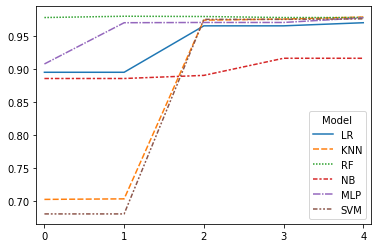

,Before,Params,Scaler,Filter,After
LR,0.895420,0.895420,0.966063,0.966063,0.970799
KNN,0.702043,0.702842,0.974747,0.976326,0.979482
RF,0.978693,0.980664,0.980269,0.978691,0.978691
NB,0.885956,0.885956,0.890692,0.916736,0.916736
MLP,0.908063,0.970799,0.971194,0.971192,0.978296
SVM,0.679942,0.679942,0.975930,0.975930,0.976718


In [ ]:
# line plot showing the predictions of different models in different phases
data = [[0.89541985199, 0.89541985199, 0.966063256, 0.966063256, 0.9707985437], [0.70204255, 0.70284242, 0.974747211999, 0.97632590375, 0.979481722], [0.9786927679, 0.9806643740, 0.980269118, 0.97869120845, 0.97869120845], [0.88595551799, 0.88595551799, 0.890691582, 0.9167364408, 0.9167364408], [0.9080626200, 0.970798544, 0.9711938, 0.97119224142, 0.97829595154], [0.679942466, 0.679942466, 0.9759298672342152, 0.9759298672342152, 0.9767180422698818]]
df = pd.DataFrame(data=data, columns=["Before", "Params", "Scaler", "Filter", "After"], index=["LR", "KNN", "RF", "NB", "MLP", "SVM"])

print(df.After)
fig, ax = plt.subplots()
sns.lineplot(data=data, legend=False)
ax.set_xlim(-0.1,4.1)
ax.set_xticks(range(0,5))
plt.legend(title='Model', loc='lower right', labels=['LR', 'KNN', 'RF', 'NB', 'MLP', 'SVM'])
plt.show()
df

#Conclusion <br>
Accuracy: 98.30% on the training data and 97.79% on the test data. <br>
Used models: KNN, MLP, SVM and Random Forest <br>


# Correlation analysis <br>

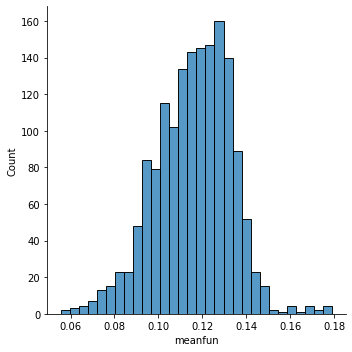

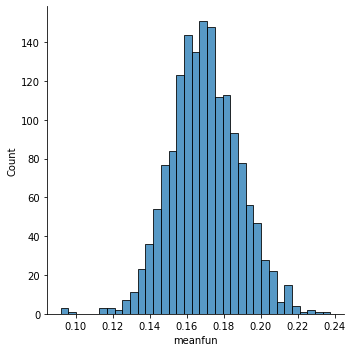

In [ ]:
# Plots of distribution for each of the features in the dataset

data_male   = data.loc[data['label'] == 1]
data_female = data.loc[data['label'] == 0]

for column in data.columns:
  print("Column:", column,"Min:", data[column].min(), "--", "Max:", data[column].max())

for column in data.columns:
  sns.displot(data, x=column)
  plt.save('.png')

sns.displot(data_male, x='meanfun')
sns.displot(data_female, x='meanfun')

In [ ]:
data = pd.read_csv("voice.csv")
data["label"] = data["label"].map(dict(male=1, female=0))

correlated_features = set()
correlation_matrix = data.corr()
#print(correlation_matrix)

print(correlation_matrix["label"].sort_values(ascending=True))

# TOP 2 highest:
# meanfun: average of fundamental frequency measured across acoustic signal
# IQR: interquantile range (in kHz)

# TOP 2 lowest:
# modindx: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of fundamental frequencies divided by the frequency range
# skew: skewness (measure of symmetry)

meanfun    -0.833921
Q25        -0.511455
meanfreq   -0.337415
centroid   -0.337415
median     -0.283919
maxdom     -0.195657
mindom     -0.194974
dfrange    -0.192213
meandom    -0.191067
mode       -0.171775
maxfun     -0.166461
minfun     -0.136692
modindx     0.030801
skew        0.036627
Q75         0.066906
kurt        0.087195
sfm         0.357499
sd          0.479539
sp.ent      0.490552
IQR         0.618916
label       1.000000
Name: label, dtype: float64


In [ ]:
# analysing the rows, where the model's prediction probability is from 0.4 to 0.6 (meaning the cases, when the model is quite unsure about the prediction)
for i in range(len(probs_test)):
  if probs_test["y_proba"].iloc[i] < 0.6 and probs_test["y_proba"].iloc[i] > 0.4:
    print(data.iloc[i].to_frame())

"""
Values are in range:
meanfreq: 0.13-0.16   
sd: 0.06-0.08           
median: 0.11-0.18            
Q75: 0.2-0.25		
IQR: 0.10-0.16		
sp.ent: 0.90-0.97		
centorid: 0.13-0.16	
meanfun: 0.10-0.12	
maxfun: 0.17-0.27		
label: 1.00
"""

# these rows are all males, whose sd value falls into the "female peak" and whose meanfun value falls into the "male peak", thus confusing the model

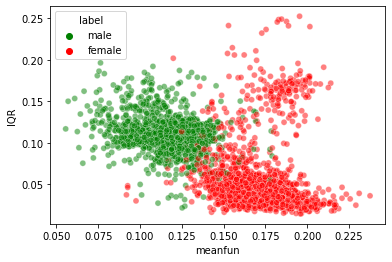

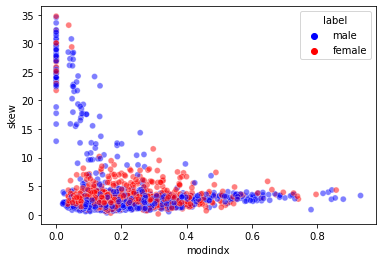

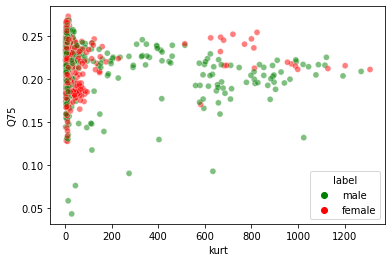

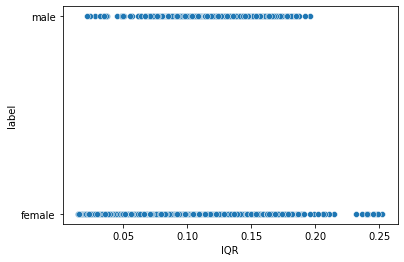

In [ ]:
# creating plots for data visualization
data = pd.read_csv("voice.csv")
data = data.sample(frac = 1)
sns.scatterplot(data=data, x="meanfun", y="IQR", hue="label", alpha=0.5, palette=('b', 'r'))
plt.show()
sns.scatterplot(data=data, x="modindx", y="skew", hue="label", alpha=0.5, palette=('b', 'r'))
plt.show()